## 1. Import Required Libraries

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.impute import SimpleImputer
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
pd.set_option('display.width', None)
print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load and Explore the OSM Wheelchair Dataset

In [37]:
# Load the OSM wheelchair data
csv_file = 'osm_wheelchair_data.csv'

print("Loading data...")
df = pd.read_csv(csv_file, low_memory=False, on_bad_lines='skip')
print(f"Total records loaded: {len(df):,}")
print(f"Total columns: {len(df.columns)}")
print(f"\nData shape: {df.shape}")

Loading data...
Total records loaded: 430,000
Total columns: 688

Data shape: (430000, 688)


## 3. Analyze ALL Available Features

Let's comprehensively explore what features we have available for training.

In [38]:
# Print ALL column names
print("=" * 80)
print("ALL AVAILABLE COLUMNS IN THE DATASET")
print("=" * 80)

all_columns = df.columns.tolist()
for i, col in enumerate(all_columns):
    print(f"{i+1:4d}. {col}")

print(f"\nTotal columns: {len(all_columns)}")

ALL AVAILABLE COLUMNS IN THE DATASET
   1. type
   2. id
   3. lat
   4. lon
   5. tags.historic
   6. tags.name
   7. tags.subject:wikidata
   8. tags.wheelchair
   9. tags.wikimedia_commons
  10. tags.amenity
  11. tags.fee
  12. tags.operator
  13. tags.description
  14. tags.description:hu
  15. tags.description:ru
  16. tags.source
  17. tags.bench
  18. tags.bin
  19. tags.building
  20. tags.loc_name
  21. tags.shelter_type
  22. tags.automatic_door
  23. tags.door
  24. tags.level
  25. tags.access
  26. tags.entrance
  27. tags.barrier
  28. tags.bottle
  29. tags.fountain
  30. tags.indoor
  31. tags.changing_table
  32. tags.check_date
  33. tags.check_date:opening_hours
  34. tags.check_date:wheelchair
  35. tags.male
  36. tags.opening_hours
  37. tags.toilets:disposal
  38. tags.natural
  39. tags.name:en
  40. tags.tourism
  41. tags.denomination
  42. tags.name:fr
  43. tags.religion
  44. tags.wikidata
  45. tags.wikipedia
  46. tags.source:name
  47. tags.addr:city
  

In [39]:
# Analyze non-null counts for all columns
print("=" * 80)
print("FEATURE AVAILABILITY ANALYSIS (sorted by coverage)")
print("=" * 80)

feature_coverage = []
total_rows = len(df)

for col in df.columns:
    non_null = df[col].notna().sum()
    pct = (non_null / total_rows) * 100
    unique = df[col].nunique()
    feature_coverage.append({
        'column': col,
        'non_null_count': non_null,
        'coverage_pct': pct,
        'unique_values': unique
    })

coverage_df = pd.DataFrame(feature_coverage).sort_values('non_null_count', ascending=False)
print(coverage_df.to_string())

FEATURE AVAILABILITY ANALYSIS (sorted by coverage)
                                               column  non_null_count  coverage_pct  unique_values
0                                                type          430000    100.000000              1
1                                                  id          430000    100.000000         430000
2                                                 lat          430000    100.000000         425806
3                                                 lon          430000    100.000000         426228
7                                     tags.wheelchair          215648     50.150698           2768
6                               tags.subject:wikidata          166084     38.624186           4935
5                                           tags.name          162391     37.765349          15244
4                                       tags.historic          157758     36.687907          13369
8                              tags.wikimedia_commons     

In [40]:
# Analyze the target variable 'wheelchair'
print("=" * 80)
print("TARGET VARIABLE ANALYSIS: tags.wheelchair")
print("=" * 80)

print("\nValue counts:")
wheelchair_counts = df['tags.wheelchair'].value_counts(dropna=False)
print(wheelchair_counts)

print("\nPercentage distribution:")
print(df['tags.wheelchair'].value_counts(normalize=True, dropna=False) * 100)

TARGET VARIABLE ANALYSIS: tags.wheelchair

Value counts:
tags.wheelchair
NaN                         214352
yes                         147443
no                           36835
limited                      11454
bus_stop                      6707
                             ...  
video                            1
cash                             1
hobby                            1
supplements                      1
Rue du Général Fauconnet         1
Name: count, Length: 2769, dtype: int64

Percentage distribution:
tags.wheelchair
NaN                         49.849302
yes                         34.289070
no                           8.566279
limited                      2.663721
bus_stop                     1.559767
                              ...    
video                        0.000233
cash                         0.000233
hobby                        0.000233
supplements                  0.000233
Rue du Général Fauconnet     0.000233
Name: proportion, Length: 2769, dtype: flo

In [41]:
# Identify ACCESSIBILITY-RELEVANT features
print("=" * 80)
print("ACCESSIBILITY-RELEVANT FEATURES IDENTIFICATION")
print("=" * 80)

# Group features by category
accessibility_features = {
    'Place Type': [
        'tags.amenity', 'tags.shop', 'tags.tourism', 'tags.leisure', 
        'tags.office', 'tags.healthcare', 'tags.building', 'tags.historic',
        'tags.natural', 'tags.place', 'tags.government', 'tags.club',
        'tags.craft', 'tags.social_facility', 'tags.public_transport'
    ],
    'Physical Access': [
        'tags.entrance', 'tags.door', 'tags.automatic_door', 'tags.access',
        'tags.barrier', 'tags.kerb', 'tags.step_count', 'tags.tactile_paving',
        'tags.ramp', 'tags.elevator', 'tags.stairs', 'tags.escalator',
        'tags.surface', 'tags.crossing', 'tags.crossing:island',
        'tags.crossing:markings', 'tags.crossing:signals', 'tags.highway'
    ],
    'Facilities & Amenities': [
        'tags.toilets', 'tags.toilets:wheelchair', 'tags.toilets:disabled',
        'tags.toilets:access', 'tags.toilets:position', 'tags.toilets:handwashing',
        'tags.changing_table', 'tags.changing_table:location', 'tags.bench',
        'tags.shelter', 'tags.drinking_water', 'tags.atm', 'tags.highchair',
        'tags.baby_feeding', 'tags.defibrillator:location'
    ],
    'Building Info': [
        'tags.level', 'tags.levels', 'tags.floor', 'tags.building:levels',
        'tags.indoor', 'tags.covered', 'tags.height', 'tags.floors', 'tags.rooms'
    ],
    'Services': [
        'tags.internet_access', 'tags.air_conditioning', 'tags.delivery',
        'tags.takeaway', 'tags.drive_through', 'tags.drive_in',
        'tags.outdoor_seating', 'tags.indoor_seating', 'tags.reservation'
    ],
    'Accessibility Indicators': [
        'tags.blind', 'tags.disabled', 'tags.hearing_loop',
        'tags.stroller', 'tags.baby', 'tags.child',
        'tags.supervised', 'tags.lit', 'tags.button_operated',
        'tags.traffic_signals:sound', 'tags.traffic_signals:vibration',
        'tags.passenger_information_display:speech_output'
    ],
    'Transport': [
        'tags.bus', 'tags.train', 'tags.tram', 'tags.railway',
        'tags.public_transport', 'tags.platforms', 'tags.departures_board',
        'tags.passenger_information_display', 'tags.aerialway'
    ],
    'Accommodation': [
        'tags.stars', 'tags.beds', 'tags.cabins', 'tags.rooms',
        'tags.caravans', 'tags.tents', 'tags.capacity', 'tags.pets_allowed'
    ],
    'Brand & Operator': [
        'tags.brand', 'tags.operator', 'tags.operator:type', 'tags.network'
    ],
    'Opening & Service': [
        'tags.opening_hours', 'tags.fee', 'tags.self_service', 'tags.automated'
    ]
}

# Print analysis for each category
for category, features in accessibility_features.items():
    print(f"\n{'='*60}")
    print(f"Category: {category}")
    print(f"{'='*60}")
    
    for feature in features:
        if feature in df.columns:
            non_null = df[feature].notna().sum()
            pct = (non_null / total_rows) * 100
            top_values = df[feature].value_counts().head(5).to_dict()
            print(f"\n  {feature}:")
            print(f"    Coverage: {non_null:,} ({pct:.2f}%)")
            print(f"    Top values: {top_values}")
        else:
            print(f"\n  {feature}: NOT IN DATASET")

ACCESSIBILITY-RELEVANT FEATURES IDENTIFICATION

Category: Place Type

  tags.amenity:
    Coverage: 60,347 (14.03%)
    Top values: {'yes': 8375, 'King County Metro': 5316, 'no': 3998, 'toilets': 2328, 'restaurant': 1402}

  tags.shop:
    Coverage: 13,598 (3.16%)
    Top values: {'yes': 5353, 'no': 1118, 'HOT-Uganda': 932, 'HOT_Uganda': 650, 'clothes': 398}

  tags.tourism:
    Coverage: 26,025 (6.05%)
    Top values: {'kerb': 9087, '0': 2193, 'disabled': 2190, 'concrete': 1737, 'yes': 1344}

  tags.leisure:
    Coverage: 5,673 (1.32%)
    Top values: {'kerb': 2493, 'yes': 823, 'Universidad Mayor de San Andrés-UMSA': 605, '0': 305, 'no': 303}

  tags.office:
    Coverage: 7,800 (1.81%)
    Top values: {'no': 3643, 'yes': 1987, 'guest_house': 206, 'disabled': 145, 'post_annex': 129}

  tags.healthcare:
    Coverage: 6,302 (1.47%)
    Top values: {'yes': 1516, 'platform': 823, 'zebra': 803, 'no': 638, 'container': 263}

  tags.building:
    Coverage: 38,810 (9.03%)
    Top values: {'yes

In [42]:
# Cross-tabulation analysis: Wheelchair accessibility by amenity type
print("=" * 80)
print("WHEELCHAIR BY AMENITY TYPE")
print("=" * 80)

if 'tags.amenity' in df.columns:
    amenity_wheelchair = pd.crosstab(
        df['tags.amenity'], 
        df['tags.wheelchair'],
        margins=True
    )
    print(amenity_wheelchair.head(30))

WHEELCHAIR BY AMENITY TYPE
tags.wheelchair                                     -1  -1;-1  -1;-2  \
tags.amenity                                                           
"D & L" Casiano                                      0      0      0   
"Obert de dilluns a divendres, matí i tarda amb...   0      0      0   
"by appointment"                                     0      0      0   
"closed"                                             0      0      0   
# SOCIAL                                             0      0      0   
'N Motion Fitness                                    0      0      0   
0                                                    0      0      0   
01001                                                0      0      0   
01002                                                0      0      0   
01004                                                0      0      0   
01005                                                0      0      0   
01006                                

In [43]:
# Cross-tabulation: Wheelchair by tourism type
print("=" * 80)
print("WHEELCHAIR BY TOURISM TYPE")
print("=" * 80)

if 'tags.tourism' in df.columns:
    tourism_wheelchair = pd.crosstab(
        df['tags.tourism'], 
        df['tags.wheelchair'],
        margins=True
    )
    print(tourism_wheelchair)

WHEELCHAIR BY TOURISM TYPE
tags.wheelchair                                     -1  -1;-1  -1;-2  -2   0  \
tags.tourism                                                                   
"Opens Tues-Sat between 6-9pm, depending on the...   0      0      0   0   0   
-1                                                   0      0      0   0   0   
-1,-2                                                0      0      0   0   0   
-1:0                                                 0      0      0   0   0   
-1;0                                                 0      0      0   0   0   
...                                                 ..    ...    ...  ..  ..   
河辺タウンビルB                                             0      0      0   0   0   
石田ビル                                                 0      0      0   0   0   
第7荒井ビル                                               0      0      0   0   0   
３レオネクストウィスタリア                                        0      0      0   0   0   
All          

In [44]:
# Cross-tabulation: Wheelchair by shop type
print("=" * 80)
print("WHEELCHAIR BY SHOP TYPE")
print("=" * 80)

if 'tags.shop' in df.columns:
    shop_wheelchair = pd.crosstab(
        df['tags.shop'], 
        df['tags.wheelchair'],
        margins=True
    )
    print(shop_wheelchair.head(30))

WHEELCHAIR BY SHOP TYPE
tags.wheelchair       -1  -2  0  08-3A  1  1;2  2  29  3  Adiskidetasun kalea  \
tags.shop                                                                       
10pin                  0   0  0      0  0    0  0   0  0                    0   
17 de agosto de 1998   0   0  0      0  0    0  0   0  0                    0   
1844                   0   0  0      0  0    0  0   0  0                    0   
1884-09-14             0   0  0      0  0    0  0   0  0                    0   
1935-05-27             0   0  0      0  0    0  0   0  0                    0   
1942                   0   0  0      0  0    0  0   0  0                    0   
1950                   0   0  0      0  0    0  0   0  0                    0   
1951                   0   0  0      0  0    0  0   0  0                    0   
1952-01                0   0  0      0  0    0  0   0  0                    0   
1960                   0   0  0      0  0    0  0   0  0                    0   
1964

In [45]:
# Cross-tabulation: Wheelchair by entrance type
print("=" * 80)
print("WHEELCHAIR BY ENTRANCE TYPE")
print("=" * 80)

if 'tags.entrance' in df.columns:
    entrance_wheelchair = pd.crosstab(
        df['tags.entrance'], 
        df['tags.wheelchair'],
        margins=True
    )
    print(entrance_wheelchair)

WHEELCHAIR BY ENTRANCE TYPE
tags.wheelchair                  -1  -1;-1  -2  -3   0  02-67  08-3A  0;0  \
tags.entrance                                                               
"Boat Launch"                     0      0   0   0   0      0      0    0   
"Cita Previa"                     0      0   0   0   0      0      0    0   
"Date de réouverture à définir"   0      0   0   0   0      0      0    0   
"con cita previa"                 0      0   0   0   0      0      0    0   
#6, 24                            0      0   0   0   0      0      0    0   
...                              ..    ...  ..  ..  ..    ...    ...  ...   
金鳳髮廊                              0      0   0   0   0      0      0    0   
銀記腸粉店                             0      0   0   0   0      0      0    0   
長興                                0      0   0   0   0      0      0    0   
雲南過橋米線                            0      0   0   0   0      0      0    0   
All                              17      1   3  

In [46]:
# Cross-tabulation: Wheelchair by automatic door
print("=" * 80)
print("WHEELCHAIR BY AUTOMATIC DOOR")
print("=" * 80)

if 'tags.automatic_door' in df.columns:
    auto_door_wheelchair = pd.crosstab(
        df['tags.automatic_door'], 
        df['tags.wheelchair'],
        margins=True
    )
    print(auto_door_wheelchair)

WHEELCHAIR BY AUTOMATIC DOOR
tags.wheelchair                    -1  -1;-1  -2  -3  -4    0  02-67  08-3A  \
tags.automatic_door                                                           
"by appointment"                    0      0   0   0   0    0      0      0   
"summer" 14:00-01:00                0      0   0   0   0    0      0      0   
+1 203-403-2558                     0      0   0   0   0    0      0      0   
+1 203-438-7778                     0      0   0   0   0    0      0      0   
+1 203-496-0293                     0      0   0   0   0    0      0      0   
...                                ..    ...  ..  ..  ..  ...    ...    ...   
小龙坎老火锅 XiaoLongKan Chinese Fondue   0      0   0   0   0    0      0      0   
湘椒老茶館 Hunan Tearoom                 0      0   0   0   0    0      0      0   
王者置業 CondoWong                      0      0   0   0   0    0      0      0   
生利海味行 S&L Dry Seafood               0      0   0   0   0    0      0      0   
All                    

In [47]:
# Cross-tabulation: Wheelchair by healthcare type
print("=" * 80)
print("WHEELCHAIR BY HEALTHCARE TYPE")
print("=" * 80)

if 'tags.healthcare' in df.columns:
    healthcare_wheelchair = pd.crosstab(
        df['tags.healthcare'], 
        df['tags.wheelchair'],
        margins=True
    )
    print(healthcare_wheelchair)

WHEELCHAIR BY HEALTHCARE TYPE
tags.wheelchair                -1  -2   0  0;1  0;1;2;3  1  2  2025-04-09  3  \
tags.healthcare                                                                
05:00-24:00                     0   0   0    0        0  0  0           0  0   
282247448466354                 0   0   0    0        0  0  0           0  0   
CafeRioLogan                    0   0   0    0        0  0  0           0  0   
Coffee-Garden-101366246591347   0   0   0    0        0  0  0           0  0   
DedalusWine                     0   0   0    0        0  0  0           0  0   
...                            ..  ..  ..  ...      ... .. ..         ... ..   
wasatch.touring                 0   0   0    0        0  0  0           0  0   
yes                             0   0   0    0        0  0  0           0  0   
大宮区                             0   0   0    0        0  0  0           0  0   
海神町                             0   0   0    0        0  0  0           0  0   
All       

In [48]:
# Analyze toilets:wheelchair feature
print("=" * 80)
print("TOILETS:WHEELCHAIR ANALYSIS")
print("=" * 80)

if 'tags.toilets:wheelchair' in df.columns:
    print("\ntoilets:wheelchair values:")
    print(df['tags.toilets:wheelchair'].value_counts())
    
    print("\nCorrelation with main wheelchair tag:")
    toilets_wc = pd.crosstab(
        df['tags.toilets:wheelchair'],
        df['tags.wheelchair'],
        margins=True
    )
    print(toilets_wc)

TOILETS:WHEELCHAIR ANALYSIS

toilets:wheelchair values:
tags.toilets:wheelchair
yes                                                                                                                   310
no                                                                                                                    260
light_rail                                                                                                             37
Eusko Trenbideak                                                                                                       14
2025-10-18                                                                                                             14
designated                                                                                                              8
2023-08-03                                                                                                              5
2025-02-23                                                        

In [49]:
# Analyze level/floor feature (ground level = more accessible)
print("=" * 80)
print("LEVEL/FLOOR ANALYSIS")
print("=" * 80)

if 'tags.level' in df.columns:
    print("\ntags.level values:")
    print(df['tags.level'].value_counts().head(20))
    
    print("\nCorrelation with wheelchair:")
    level_wc = pd.crosstab(
        df['tags.level'],
        df['tags.wheelchair'],
        margins=True
    )
    print(level_wc.head(15))

LEVEL/FLOOR ANALYSIS

tags.level values:
tags.level
yes                        2580
TTC                        2346
0                           723
no                          598
pharmacy                    547
post_annex                  427
Montpellier                 260
subway_entrance             246
1                           244
Hamilton Street Railway     230
2                           131
private                     128
post_partner                116
station                     113
Sète                        112
York Region Transit         107
clinic                      106
customers                    96
dentist                      87
24/7                         83
Name: count, dtype: int64

Correlation with wheelchair:
tags.wheelchair        -1  -2  -3  0  0;1;2;3;4  1  1-3  10  2  2023-10-31  \
tags.level                                                                   
"The other side"        0   0   0  0          0  0    0   0  0           0   
"by appointment on

## 4. Prepare 3-Class Target Variable

Combine 'yes' and 'designated' into one class, keep 'limited' and 'no' as separate classes.

In [50]:
# Create 3-class target
print("=" * 80)
print("CREATING 3-CLASS TARGET VARIABLE")
print("=" * 80)

def create_3class_target(val):
    """Convert wheelchair values to 3 classes:
    - 2: accessible (yes, designated)
    - 1: limited
    - 0: not_accessible (no)
    """
    if pd.isna(val):
        return np.nan
    val = str(val).lower().strip()
    if val in ['yes', 'designated']:
        return 2  # Accessible
    elif val == 'limited':
        return 1  # Limited
    elif val == 'no':
        return 0  # Not accessible
    else:
        return np.nan  # Unknown

# Filter for labeled data
df_labeled = df[df['tags.wheelchair'].notna()].copy()
print(f"Records with wheelchair label: {len(df_labeled):,}")

# Apply 3-class transformation
df_labeled['target_3class'] = df_labeled['tags.wheelchair'].apply(create_3class_target)
df_labeled = df_labeled[df_labeled['target_3class'].notna()]

print(f"\nFinal dataset size: {len(df_labeled):,}")
print("\n3-Class distribution:")
class_names = {0: 'not_accessible', 1: 'limited', 2: 'accessible'}
print(df_labeled['target_3class'].map(class_names).value_counts())
print("\nPercentage:")
print((df_labeled['target_3class'].map(class_names).value_counts(normalize=True) * 100).round(2))

CREATING 3-CLASS TARGET VARIABLE
Records with wheelchair label: 215,648

Final dataset size: 195,942

3-Class distribution:
target_3class
accessible        147653
not_accessible     36835
limited            11454
Name: count, dtype: int64

Percentage:
target_3class
accessible        75.36
not_accessible    18.80
limited            5.85
Name: proportion, dtype: float64


## 5. Comprehensive Feature Engineering

Build features from all relevant OSM tags.

In [51]:
# Define comprehensive feature list (expanded from original)
comprehensive_features = [
    # Place type features
    'tags.amenity', 'tags.shop', 'tags.tourism', 'tags.leisure',
    'tags.office', 'tags.healthcare', 'tags.building', 'tags.historic',
    'tags.public_transport', 'tags.railway', 'tags.highway', 'tags.natural',
    'tags.government', 'tags.club', 'tags.craft', 'tags.social_facility',
    
    # Physical access features
    'tags.entrance', 'tags.door', 'tags.automatic_door', 'tags.access',
    'tags.barrier', 'tags.kerb', 'tags.step_count', 'tags.tactile_paving',
    'tags.surface', 'tags.crossing', 'tags.crossing:markings',
    
    # Facilities features
    'tags.toilets', 'tags.toilets:wheelchair', 'tags.toilets:disabled',
    'tags.toilets:access', 'tags.toilets:position', 'tags.toilets:handwashing',
    'tags.changing_table', 'tags.changing_table:location',
    'tags.bench', 'tags.shelter', 'tags.drinking_water',
    'tags.atm', 'tags.highchair', 'tags.defibrillator:location',
    
    # Building structure
    'tags.level', 'tags.floor', 'tags.building:levels', 'tags.floors',
    'tags.indoor', 'tags.covered', 'tags.height', 'tags.rooms',
    
    # Services
    'tags.internet_access', 'tags.air_conditioning', 'tags.delivery',
    'tags.takeaway', 'tags.drive_through', 'tags.drive_in',
    'tags.outdoor_seating', 'tags.indoor_seating', 'tags.reservation',
    'tags.self_service', 'tags.automated',
    
    # Accessibility indicators
    'tags.blind', 'tags.disabled', 'tags.hearing_loop', 'tags.stroller',
    'tags.baby', 'tags.child', 'tags.supervised', 'tags.lit',
    'tags.button_operated', 'tags.traffic_signals:sound',
    'tags.traffic_signals:vibration',
    
    # Transport
    'tags.bus', 'tags.train', 'tags.tram', 'tags.platforms',
    'tags.departures_board', 'tags.passenger_information_display',
    
    # Accommodation
    'tags.stars', 'tags.beds', 'tags.capacity', 'tags.pets_allowed',
    
    # Brand & operator (chain businesses often more accessible)
    'tags.brand', 'tags.operator', 'tags.operator:type', 'tags.network',
    
    # Opening hours (24h places may be more accessible)
    'tags.opening_hours', 'tags.fee',
    
    # Cuisine/diet (restaurant features)
    'tags.cuisine', 'tags.diet:vegetarian', 'tags.diet:vegan',
    
    # Additional useful features
    'tags.smoking', 'tags.outdoor', 'tags.information',
    'tags.religion', 'tags.denomination', 'tags.sport',
    'tags.museum', 'tags.gallery'
]

# Check availability
available_features = [f for f in comprehensive_features if f in df_labeled.columns]
print(f"Features defined: {len(comprehensive_features)}")
print(f"Features available in data: {len(available_features)}")
print(f"\nAvailable features:")
for i, f in enumerate(available_features, 1):
    print(f"  {i:2d}. {f}")

Features defined: 98
Features available in data: 98

Available features:
   1. tags.amenity
   2. tags.shop
   3. tags.tourism
   4. tags.leisure
   5. tags.office
   6. tags.healthcare
   7. tags.building
   8. tags.historic
   9. tags.public_transport
  10. tags.railway
  11. tags.highway
  12. tags.natural
  13. tags.government
  14. tags.club
  15. tags.craft
  16. tags.social_facility
  17. tags.entrance
  18. tags.door
  19. tags.automatic_door
  20. tags.access
  21. tags.barrier
  22. tags.kerb
  23. tags.step_count
  24. tags.tactile_paving
  25. tags.surface
  26. tags.crossing
  27. tags.crossing:markings
  28. tags.toilets
  29. tags.toilets:wheelchair
  30. tags.toilets:disabled
  31. tags.toilets:access
  32. tags.toilets:position
  33. tags.toilets:handwashing
  34. tags.changing_table
  35. tags.changing_table:location
  36. tags.bench
  37. tags.shelter
  38. tags.drinking_water
  39. tags.atm
  40. tags.highchair
  41. tags.defibrillator:location
  42. tags.level
  43

In [52]:
# Analyze feature coverage in labeled data
print("=" * 80)
print("FEATURE COVERAGE IN LABELED DATA")
print("=" * 80)

feature_stats = []
for col in available_features:
    non_null = df_labeled[col].notna().sum()
    pct = (non_null / len(df_labeled)) * 100
    unique = df_labeled[col].nunique()
    feature_stats.append({
        'feature': col,
        'non_null_count': non_null,
        'coverage_pct': round(pct, 2),
        'unique_values': unique
    })

stats_df = pd.DataFrame(feature_stats).sort_values('coverage_pct', ascending=False)
print(stats_df.to_string())

# Select features with at least 0.5% coverage
min_coverage = 0.5
useful_features = stats_df[stats_df['coverage_pct'] >= min_coverage]['feature'].tolist()
print(f"\n\nFeatures with >= {min_coverage}% coverage: {len(useful_features)}")

FEATURE COVERAGE IN LABELED DATA
                               feature  non_null_count  coverage_pct  unique_values
7                        tags.historic          108180         55.21            667
0                         tags.amenity           23835         12.16           7325
82                       tags.operator           16512          8.43           1446
86                            tags.fee           15891          8.11           2947
35                          tags.bench           14064          7.18           4869
16                       tags.entrance           12895          6.58           3954
18                 tags.automatic_door           11074          5.65           3768
20                        tags.barrier           10103          5.16           2997
6                        tags.building            9772          4.99           2407
2                         tags.tourism            9214          4.70            975
94                   tags.denomination     

In [53]:
# Advanced feature encoding
def encode_features_advanced(df, feature_cols, n_top_categories=15):
    """
    Create comprehensive encoded feature matrix from categorical OSM tags.
    
    Features created:
    1. has_{feature} - binary flag for presence
    2. {feature}_{category} - one-hot encoding for top categories
    3. Numeric features where applicable
    """
    encoded_features = pd.DataFrame(index=df.index)
    
    for col in feature_cols:
        if col not in df.columns:
            continue
        
        col_name = col.replace('tags.', '').replace(':', '_')
        
        # 1. Binary presence flag
        encoded_features[f'has_{col_name}'] = df[col].notna().astype(int)
        
        # 2. Handle special boolean-like columns
        if col in ['tags.toilets:wheelchair', 'tags.toilets:disabled', 
                   'tags.automatic_door', 'tags.blind', 'tags.disabled',
                   'tags.hearing_loop', 'tags.tactile_paving', 'tags.lit',
                   'tags.button_operated']:
            # Convert yes/no to 1/0
            df_temp = df[col].fillna('').astype(str).str.lower()
            encoded_features[f'{col_name}_yes'] = df_temp.isin(['yes', 'true', '1']).astype(int)
            encoded_features[f'{col_name}_no'] = df_temp.isin(['no', 'false', '0']).astype(int)
        
        # 3. Handle numeric-like columns
        elif col in ['tags.level', 'tags.floor', 'tags.floors', 'tags.building:levels',
                     'tags.stars', 'tags.step_count', 'tags.capacity', 'tags.rooms']:
            try:
                numeric_vals = pd.to_numeric(df[col], errors='coerce')
                encoded_features[f'{col_name}_numeric'] = numeric_vals.fillna(-999)
                # Ground level indicator
                if col in ['tags.level', 'tags.floor']:
                    encoded_features[f'{col_name}_ground'] = (numeric_vals == 0).astype(int)
                    encoded_features[f'{col_name}_basement'] = (numeric_vals < 0).astype(int)
                    encoded_features[f'{col_name}_upper'] = (numeric_vals > 0).astype(int)
            except:
                pass
        
        # 4. One-hot encode top categories for categorical features
        if df[col].notna().sum() > 0:
            value_counts = df[col].value_counts()
            top_categories = value_counts.head(n_top_categories).index.tolist()
            
            for cat in top_categories:
                cat_str = str(cat).replace(' ', '_').replace('-', '_').replace('/', '_')[:25]
                encoded_features[f'{col_name}_{cat_str}'] = (df[col] == cat).astype(int)
    
    # 5. Create interaction features
    # Automatic door + entrance type
    if 'has_automatic_door' in encoded_features.columns and 'has_entrance' in encoded_features.columns:
        encoded_features['auto_door_with_entrance'] = (
            encoded_features['has_automatic_door'] * encoded_features['has_entrance']
        )
    
    # Toilets wheelchair + toilets presence
    if 'has_toilets_wheelchair' in encoded_features.columns and 'has_toilets' in encoded_features.columns:
        encoded_features['accessible_toilets_combo'] = (
            encoded_features['has_toilets_wheelchair'] * encoded_features['has_toilets']
        )
    
    # Brand presence (chain stores often more accessible)
    if 'has_brand' in encoded_features.columns:
        encoded_features['is_chain_store'] = encoded_features['has_brand']
    
    return encoded_features

print("Encoding features...")
X = encode_features_advanced(df_labeled, useful_features)
y = df_labeled['target_3class'].astype(int)

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nNumber of features: {X.shape[1]}")

Encoding features...

Feature matrix shape: (195942, 798)
Target shape: (195942,)

Number of features: 798


In [54]:
# Print all generated features
print("=" * 80)
print("ALL GENERATED FEATURES")
print("=" * 80)

for i, col in enumerate(X.columns, 1):
    print(f"{i:4d}. {col}")

print(f"\nTotal features: {len(X.columns)}")

ALL GENERATED FEATURES
   1. has_historic
   2. historic_kerb
   3. historic_gate
   4. historic_yes
   5. historic_bollard
   6. historic_no
   7. historic_swing_gate
   8. historic_2022_12_10
   9. historic_2024_06_27
  10. historic_2024_08_12
  11. historic_2025_01_21
  12. historic_2025_01_17
  13. historic_2024_08_18
  14. historic_2025_05_19
  15. historic_2024_09_20
  16. historic_2024_05_20
  17. has_amenity
  18. amenity_toilets
  19. amenity_restaurant
  20. amenity_cafe
  21. amenity_yes
  22. amenity_fast_food
  23. amenity_hinged
  24. amenity_bus_stop
  25. amenity_drinking_water
  26. amenity_private
  27. amenity_no
  28. amenity_bank
  29. amenity_Metro_de_Madrid
  30. amenity_15121
  31. amenity_48920
  32. amenity_pharmacy
  33. has_operator
  34. operator_toilets
  35. operator_Cochabamba
  36. operator_Yarra_Trams
  37. operator_restaurant
  38. operator_bus_stop
  39. operator_Ciudad_Satélite
  40. operator_pharmacy
  41. operator_shower
  42. operator_fast_food
 

## 6. Geographic Train-Test Split (Reduce Spatial Leakage)

Split by continent/region to test generalization to unseen geographic areas.

In [55]:
# Define continent/region based on lat/lon
def assign_continent(lat, lon):
    """Assign continent based on latitude and longitude coordinates."""
    if pd.isna(lat) or pd.isna(lon):
        return 'Unknown'
    
    # Europe
    if 35 <= lat <= 71 and -25 <= lon <= 65:
        # Subdivide Europe into regions for finer control
        if lon < 10:
            return 'Europe_West'
        elif lon < 25:
            return 'Europe_Central'
        else:
            return 'Europe_East'
    
    # North America
    if 15 <= lat <= 85 and -170 <= lon <= -50:
        if lat > 49:
            return 'North_America_Canada'
        elif lon < -100:
            return 'North_America_West'
        else:
            return 'North_America_East'
    
    # South America
    if -60 <= lat <= 15 and -85 <= lon <= -30:
        return 'South_America'
    
    # Africa
    if -35 <= lat <= 37 and -20 <= lon <= 55:
        if lat > 0:
            return 'Africa_North'
        else:
            return 'Africa_South'
    
    # Asia
    if -10 <= lat <= 80 and 65 <= lon <= 180:
        if lat > 35:
            return 'Asia_North'
        else:
            return 'Asia_South'
    
    # Oceania (Australia, New Zealand, Pacific)
    if -50 <= lat <= 0 and 100 <= lon <= 180:
        return 'Oceania'
    
    # Middle East
    if 12 <= lat <= 45 and 25 <= lon <= 65:
        return 'Middle_East'
    
    return 'Other'

# Assign regions to labeled data
print("=" * 80)
print("GEOGRAPHIC REGION ASSIGNMENT")
print("=" * 80)

df_labeled['region'] = df_labeled.apply(lambda row: assign_continent(row['lat'], row['lon']), axis=1)

print("\nData distribution by region:")
region_counts = df_labeled['region'].value_counts()
print(region_counts)

print("\nPercentage by region:")
print((region_counts / len(df_labeled) * 100).round(2))

GEOGRAPHIC REGION ASSIGNMENT

Data distribution by region:
region
North_America_East    108824
Europe_West            27463
North_America_West     27264
South_America          17478
Oceania                 9217
Africa_South            4179
Other                    862
Asia_South               432
Asia_North               223
Name: count, dtype: int64

Percentage by region:
region
North_America_East    55.54
Europe_West           14.02
North_America_West    13.91
South_America          8.92
Oceania                4.70
Africa_South           2.13
Other                  0.44
Asia_South             0.22
Asia_North             0.11
Name: count, dtype: float64


GEOGRAPHIC DISTRIBUTION VISUALIZATION


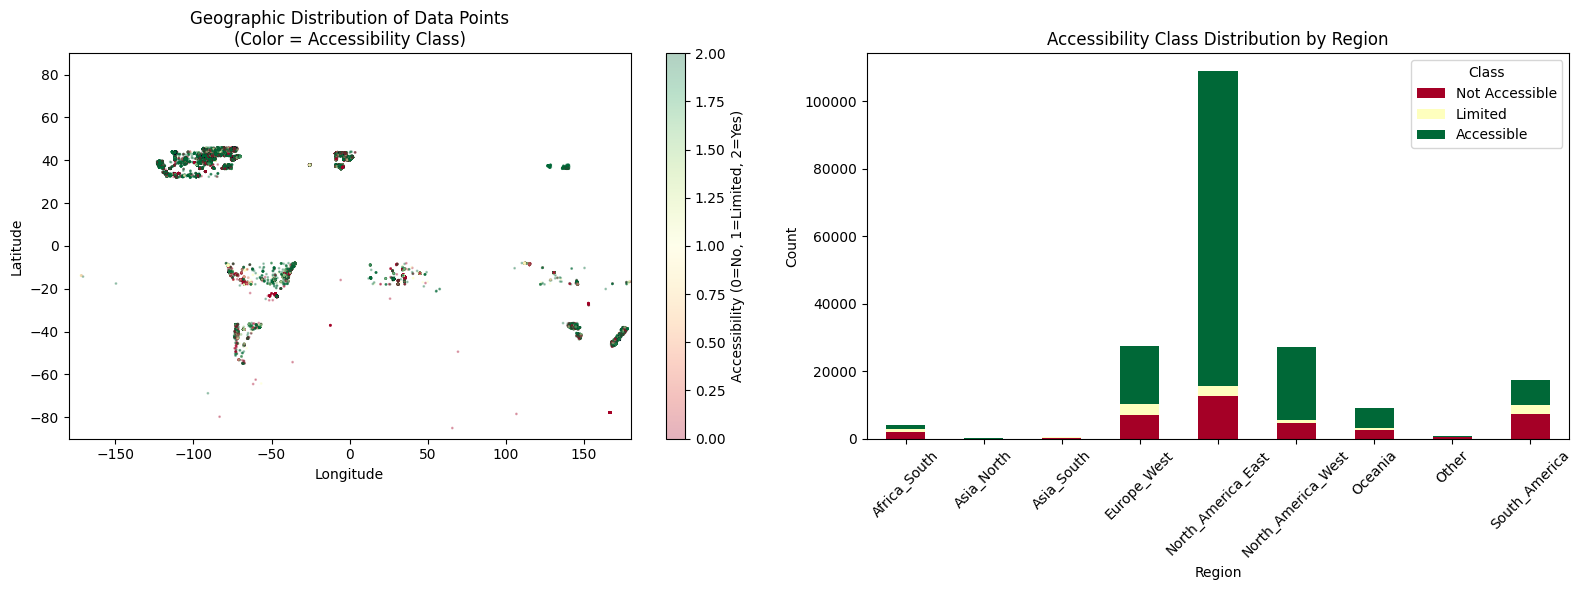


Class distribution by region (percentage):
                    not_accessible  limited  accessible
region                                                 
Africa_South                 50.49    19.67       29.84
Asia_North                    5.83     0.00       94.17
Asia_South                   38.43    44.68       16.90
Europe_West                  25.92    11.45       62.63
North_America_East           11.56     2.73       85.71
North_America_West           16.67     3.27       80.06
Oceania                      27.93     7.68       64.39
Other                        51.16     9.40       39.44
South_America                41.69    15.13       43.18


In [56]:
# Visualize geographic distribution
print("=" * 80)
print("GEOGRAPHIC DISTRIBUTION VISUALIZATION")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Data points on world map
ax1 = axes[0]
scatter = ax1.scatter(
    df_labeled['lon'], 
    df_labeled['lat'], 
    c=df_labeled['target_3class'], 
    cmap='RdYlGn', 
    alpha=0.3, 
    s=1
)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Geographic Distribution of Data Points\n(Color = Accessibility Class)')
ax1.set_xlim(-180, 180)
ax1.set_ylim(-90, 90)
plt.colorbar(scatter, ax=ax1, label='Accessibility (0=No, 1=Limited, 2=Yes)')

# Plot 2: Class distribution by region
ax2 = axes[1]
region_class_dist = df_labeled.groupby(['region', 'target_3class']).size().unstack(fill_value=0)
region_class_dist.plot(kind='bar', stacked=True, ax=ax2, colormap='RdYlGn')
ax2.set_xlabel('Region')
ax2.set_ylabel('Count')
ax2.set_title('Accessibility Class Distribution by Region')
ax2.legend(['Not Accessible', 'Limited', 'Accessible'], title='Class')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Show class distribution per region
print("\nClass distribution by region (percentage):")
region_class_pct = df_labeled.groupby('region')['target_3class'].value_counts(normalize=True).unstack(fill_value=0) * 100
region_class_pct.columns = ['not_accessible', 'limited', 'accessible']
print(region_class_pct.round(2))

In [57]:
# Geographic Split Strategy: Hold out entire regions for testing
print("=" * 80)
print("GEOGRAPHIC TRAIN-TEST SPLIT")
print("=" * 80)

# Strategy: Use major European regions for training, hold out other continents for testing
# This tests if the model generalizes across different geographic/cultural contexts

# Define train and test regions
# Training: Europe (largest data source, diverse countries)
train_regions = ['Europe_West', 'Europe_Central', 'Europe_East']

# Testing: Held-out continents to test generalization
test_regions = ['North_America_East', 'North_America_West', 'North_America_Canada', 
                'Oceania', 'Asia_North', 'Asia_South', 'South_America',
                'Africa_North', 'Africa_South', 'Middle_East', 'Other']

# Create train/test masks
train_mask = df_labeled['region'].isin(train_regions)
test_mask = df_labeled['region'].isin(test_regions)

# Check if we have enough test data
train_count = train_mask.sum()
test_count = test_mask.sum()

print(f"\nInitial split:")
print(f"  Training (Europe): {train_count:,} samples ({train_count/len(df_labeled)*100:.1f}%)")
print(f"  Testing (Other continents): {test_count:,} samples ({test_count/len(df_labeled)*100:.1f}%)")

# If test set is too small, add more regions to test
if test_count < 0.15 * len(df_labeled):
    print("\n⚠️ Test set too small, adjusting split...")
    # Move some European data to test set
    # Randomly sample from training regions
    np.random.seed(42)
    train_indices = df_labeled[train_mask].index.tolist()
    n_to_move = int(0.15 * len(df_labeled)) - test_count
    move_indices = np.random.choice(train_indices, size=min(n_to_move, len(train_indices)//4), replace=False)
    train_mask.loc[move_indices] = False
    test_mask.loc[move_indices] = True

print(f"\nFinal geographic split:")
print(f"  Training: {train_mask.sum():,} samples")
print(f"  Testing: {test_mask.sum():,} samples")

GEOGRAPHIC TRAIN-TEST SPLIT

Initial split:
  Training (Europe): 27,463 samples (14.0%)
  Testing (Other continents): 168,479 samples (86.0%)

Final geographic split:
  Training: 27,463 samples
  Testing: 168,479 samples


In [58]:
# Create geographic train/test split
X_train_geo = X.loc[train_mask]
X_test_geo = X.loc[test_mask]
y_train_geo = y.loc[train_mask]
y_test_geo = y.loc[test_mask]

print("=" * 80)
print("GEOGRAPHIC SPLIT SUMMARY")
print("=" * 80)

print(f"\nTraining set: {X_train_geo.shape[0]:,} samples")
print(f"Testing set: {X_test_geo.shape[0]:,} samples")

print(f"\nClass distribution in TRAINING set (Europe):")
print(y_train_geo.map(class_names).value_counts())
print("\nPercentage:")
print((y_train_geo.map(class_names).value_counts(normalize=True) * 100).round(2))

print(f"\nClass distribution in TESTING set (Other Continents):")
print(y_test_geo.map(class_names).value_counts())
print("\nPercentage:")
print((y_test_geo.map(class_names).value_counts(normalize=True) * 100).round(2))

# Show which regions are in test set
print("\nTest set regions:")
test_region_counts = df_labeled.loc[test_mask, 'region'].value_counts()
print(test_region_counts)

# Use geographic split instead of random split
X_train, X_test = X_train_geo, X_test_geo
y_train, y_test = y_train_geo, y_test_geo

GEOGRAPHIC SPLIT SUMMARY

Training set: 27,463 samples
Testing set: 168,479 samples

Class distribution in TRAINING set (Europe):
target_3class
accessible        17200
not_accessible     7118
limited            3145
Name: count, dtype: int64

Percentage:
target_3class
accessible        62.63
not_accessible    25.92
limited           11.45
Name: proportion, dtype: float64

Class distribution in TESTING set (Other Continents):
target_3class
accessible        130453
not_accessible     29717
limited             8309
Name: count, dtype: int64

Percentage:
target_3class
accessible        77.43
not_accessible    17.64
limited            4.93
Name: proportion, dtype: float64

Test set regions:
region
North_America_East    108824
North_America_West     27264
South_America          17478
Oceania                 9217
Africa_South            4179
Other                    862
Asia_South               432
Asia_North               223
Name: count, dtype: int64


In [59]:
# Alternative: Leave-One-Region-Out Cross-Validation for more robust evaluation
print("=" * 80)
print("LEAVE-ONE-REGION-OUT CROSS-VALIDATION SETUP")
print("=" * 80)

# Get unique regions with sufficient data
region_counts = df_labeled['region'].value_counts()
valid_regions = region_counts[region_counts >= 100].index.tolist()
print(f"\nRegions with >= 100 samples: {len(valid_regions)}")
for region in valid_regions:
    print(f"  {region}: {region_counts[region]:,} samples")

# Create region-based fold assignments
from sklearn.model_selection import LeaveOneGroupOut

df_labeled_valid = df_labeled[df_labeled['region'].isin(valid_regions)].copy()
X_valid = X.loc[df_labeled_valid.index]
y_valid = y.loc[df_labeled_valid.index]
groups = df_labeled_valid['region'].values

logo = LeaveOneGroupOut()
n_splits = logo.get_n_splits(X_valid, y_valid, groups)
print(f"\nNumber of folds for Leave-One-Region-Out CV: {n_splits}")

LEAVE-ONE-REGION-OUT CROSS-VALIDATION SETUP

Regions with >= 100 samples: 9
  North_America_East: 108,824 samples
  Europe_West: 27,463 samples
  North_America_West: 27,264 samples
  South_America: 17,478 samples
  Oceania: 9,217 samples
  Africa_South: 4,179 samples
  Other: 862 samples
  Asia_South: 432 samples
  Asia_North: 223 samples

Number of folds for Leave-One-Region-Out CV: 9


In [60]:
# Run Leave-One-Region-Out Cross-Validation
print("=" * 80)
print("LEAVE-ONE-REGION-OUT CV RESULTS")
print("=" * 80)

# Use a fast model for CV
from sklearn.ensemble import HistGradientBoostingClassifier

cv_model = HistGradientBoostingClassifier(
    max_iter=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)

# Store results per region
region_results = []

print("\nRunning Leave-One-Region-Out CV...")
for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X_valid, y_valid, groups)):
    # Get the held-out region name
    test_region = df_labeled_valid.iloc[test_idx]['region'].iloc[0]
    
    X_fold_train = X_valid.iloc[train_idx]
    X_fold_test = X_valid.iloc[test_idx]
    y_fold_train = y_valid.iloc[train_idx]
    y_fold_test = y_valid.iloc[test_idx]
    
    # Train and evaluate
    cv_model.fit(X_fold_train, y_fold_train)
    y_pred = cv_model.predict(X_fold_test)
    
    # Calculate metrics
    acc = accuracy_score(y_fold_test, y_pred)
    f1_macro = f1_score(y_fold_test, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_fold_test, y_pred, average='weighted', zero_division=0)
    
    region_results.append({
        'region': test_region,
        'n_samples': len(test_idx),
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    })
    
    print(f"  Fold {fold_idx+1}: Test on {test_region:25s} | "
          f"Samples: {len(test_idx):6,} | Acc: {acc:.3f} | F1-macro: {f1_macro:.3f}")

# Summary
results_df = pd.DataFrame(region_results)
print("\n" + "=" * 80)
print("GEOGRAPHIC GENERALIZATION SUMMARY")
print("=" * 80)

print(f"\nMean Accuracy across regions: {results_df['accuracy'].mean():.3f} (±{results_df['accuracy'].std():.3f})")
print(f"Mean F1-macro across regions: {results_df['f1_macro'].mean():.3f} (±{results_df['f1_macro'].std():.3f})")
print(f"Mean F1-weighted across regions: {results_df['f1_weighted'].mean():.3f} (±{results_df['f1_weighted'].std():.3f})")

print("\n" + "-" * 80)
print("Performance by Region (sorted by F1-macro):")
print("-" * 80)
print(results_df.sort_values('f1_macro', ascending=False).to_string(index=False))

LEAVE-ONE-REGION-OUT CV RESULTS

Running Leave-One-Region-Out CV...
  Fold 1: Test on Africa_South              | Samples:  4,179 | Acc: 0.198 | F1-macro: 0.117
  Fold 2: Test on Asia_North                | Samples:    223 | Acc: 0.659 | F1-macro: 0.374
  Fold 3: Test on Asia_South                | Samples:    432 | Acc: 0.419 | F1-macro: 0.214
  Fold 4: Test on Europe_West               | Samples: 27,463 | Acc: 0.316 | F1-macro: 0.305
  Fold 5: Test on North_America_East        | Samples: 108,824 | Acc: 0.761 | F1-macro: 0.385
  Fold 6: Test on North_America_West        | Samples: 27,264 | Acc: 0.683 | F1-macro: 0.363
  Fold 7: Test on Oceania                   | Samples:  9,217 | Acc: 0.219 | F1-macro: 0.244
  Fold 8: Test on Other                     | Samples:    862 | Acc: 0.088 | F1-macro: 0.074
  Fold 9: Test on South_America             | Samples: 17,478 | Acc: 0.204 | F1-macro: 0.198

GEOGRAPHIC GENERALIZATION SUMMARY

Mean Accuracy across regions: 0.394 (±0.248)
Mean F1-macro

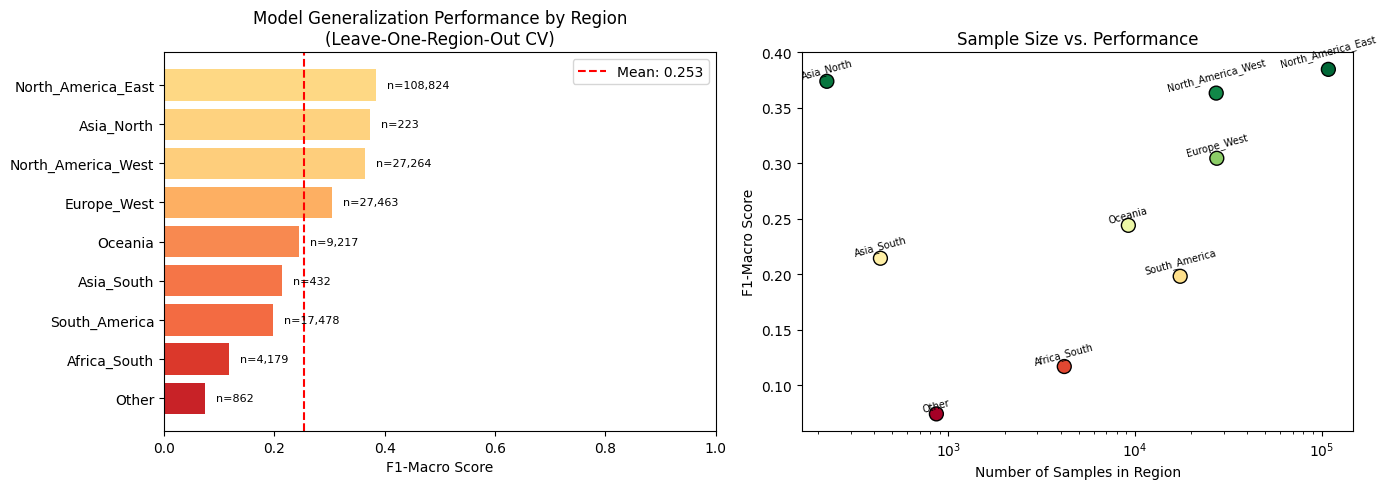


⚠️ Regions with below-average performance:
  Other: F1=0.074 (n=862)
  Africa_South: F1=0.117 (n=4,179)
  South_America: F1=0.198 (n=17,478)
  Asia_South: F1=0.214 (n=432)
  Oceania: F1=0.244 (n=9,217)


In [61]:
# Visualize geographic generalization performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Performance by region
ax1 = axes[0]
results_sorted = results_df.sort_values('f1_macro', ascending=True)
colors = plt.cm.RdYlGn(results_sorted['f1_macro'])
bars = ax1.barh(results_sorted['region'], results_sorted['f1_macro'], color=colors)
ax1.axvline(x=results_df['f1_macro'].mean(), color='red', linestyle='--', label=f'Mean: {results_df["f1_macro"].mean():.3f}')
ax1.set_xlabel('F1-Macro Score')
ax1.set_title('Model Generalization Performance by Region\n(Leave-One-Region-Out CV)')
ax1.legend()
ax1.set_xlim(0, 1)

# Add sample size annotations
for bar, n_samples in zip(bars, results_sorted['n_samples']):
    ax1.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, 
             f'n={n_samples:,}', va='center', fontsize=8)

# Plot 2: Sample size vs performance
ax2 = axes[1]
ax2.scatter(results_df['n_samples'], results_df['f1_macro'], 
            s=100, c=results_df['f1_macro'], cmap='RdYlGn', edgecolors='black')
for idx, row in results_df.iterrows():
    ax2.annotate(row['region'], (row['n_samples'], row['f1_macro']), 
                 fontsize=7, ha='center', va='bottom', rotation=15)
ax2.set_xlabel('Number of Samples in Region')
ax2.set_ylabel('F1-Macro Score')
ax2.set_title('Sample Size vs. Performance')
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

# Identify regions where model struggles
print("\n⚠️ Regions with below-average performance:")
mean_f1 = results_df['f1_macro'].mean()
weak_regions = results_df[results_df['f1_macro'] < mean_f1].sort_values('f1_macro')
for _, row in weak_regions.iterrows():
    print(f"  {row['region']}: F1={row['f1_macro']:.3f} (n={row['n_samples']:,})")

In [62]:
# Compare random split vs geographic split performance
print("=" * 80)
print("COMPARISON: RANDOM SPLIT vs GEOGRAPHIC SPLIT")
print("=" * 80)

# Train model with random split for comparison
X_train_random, X_test_random, y_train_random, y_test_random = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

comparison_model = HistGradientBoostingClassifier(
    max_iter=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)

# Random split evaluation
comparison_model.fit(X_train_random, y_train_random)
y_pred_random = comparison_model.predict(X_test_random)
random_acc = accuracy_score(y_test_random, y_pred_random)
random_f1_macro = f1_score(y_test_random, y_pred_random, average='macro')
random_f1_weighted = f1_score(y_test_random, y_pred_random, average='weighted')

# Geographic split evaluation
comparison_model.fit(X_train, y_train)
y_pred_geo = comparison_model.predict(X_test)
geo_acc = accuracy_score(y_test, y_pred_geo)
geo_f1_macro = f1_score(y_test, y_pred_geo, average='macro')
geo_f1_weighted = f1_score(y_test, y_pred_geo, average='weighted')

print("\n" + "-" * 60)
print(f"{'Metric':<25} {'Random Split':<15} {'Geographic Split':<15} {'Δ':<10}")
print("-" * 60)
print(f"{'Accuracy':<25} {random_acc:<15.3f} {geo_acc:<15.3f} {geo_acc - random_acc:+.3f}")
print(f"{'F1-Macro':<25} {random_f1_macro:<15.3f} {geo_f1_macro:<15.3f} {geo_f1_macro - random_f1_macro:+.3f}")
print(f"{'F1-Weighted':<25} {random_f1_weighted:<15.3f} {geo_f1_weighted:<15.3f} {geo_f1_weighted - random_f1_weighted:+.3f}")
print("-" * 60)

perf_drop = ((random_f1_macro - geo_f1_macro) / random_f1_macro) * 100
print(f"\n📊 Performance drop with geographic split: {perf_drop:.1f}%")

if perf_drop > 10:
    print("⚠️ Significant spatial leakage detected! Random split overestimates model performance.")
    print("   The geographic split provides a more realistic estimate of real-world performance.")
elif perf_drop > 5:
    print("⚡ Moderate spatial leakage detected. Geographic split is recommended for evaluation.")
else:
    print("✅ Model generalizes well across regions. Low spatial leakage.")

COMPARISON: RANDOM SPLIT vs GEOGRAPHIC SPLIT

------------------------------------------------------------
Metric                    Random Split    Geographic Split Δ         
------------------------------------------------------------
Accuracy                  0.663           0.661           -0.002
F1-Macro                  0.526           0.407           -0.119
F1-Weighted               0.719           0.693           -0.026
------------------------------------------------------------

📊 Performance drop with geographic split: 22.6%
⚠️ Significant spatial leakage detected! Random split overestimates model performance.
   The geographic split provides a more realistic estimate of real-world performance.


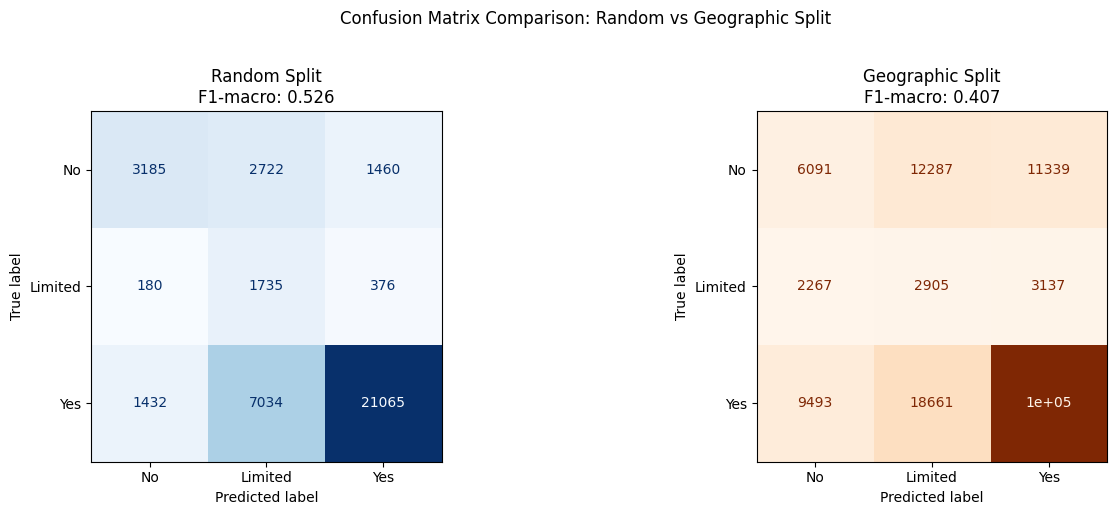


CLASSIFICATION REPORT - RANDOM SPLIT
                precision    recall  f1-score   support

not_accessible       0.66      0.43      0.52      7367
       limited       0.15      0.76      0.25      2291
    accessible       0.92      0.71      0.80     29531

      accuracy                           0.66     39189
     macro avg       0.58      0.63      0.53     39189
  weighted avg       0.83      0.66      0.72     39189


CLASSIFICATION REPORT - GEOGRAPHIC SPLIT
                precision    recall  f1-score   support

not_accessible       0.34      0.20      0.26     29717
       limited       0.09      0.35      0.14      8309
    accessible       0.88      0.78      0.83    130453

      accuracy                           0.66    168479
     macro avg       0.43      0.45      0.41    168479
  weighted avg       0.74      0.66      0.69    168479



In [63]:
# Detailed confusion matrices comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Random split confusion matrix
ax1 = axes[0]
cm_random = confusion_matrix(y_test_random, y_pred_random)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_random, display_labels=['No', 'Limited', 'Yes'])
disp1.plot(ax=ax1, cmap='Blues', colorbar=False)
ax1.set_title(f'Random Split\nF1-macro: {random_f1_macro:.3f}')

# Geographic split confusion matrix
ax2 = axes[1]
cm_geo = confusion_matrix(y_test, y_pred_geo)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_geo, display_labels=['No', 'Limited', 'Yes'])
disp2.plot(ax=ax2, cmap='Oranges', colorbar=False)
ax2.set_title(f'Geographic Split\nF1-macro: {geo_f1_macro:.3f}')

plt.suptitle('Confusion Matrix Comparison: Random vs Geographic Split', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

# Classification reports
print("\n" + "=" * 80)
print("CLASSIFICATION REPORT - RANDOM SPLIT")
print("=" * 80)
print(classification_report(y_test_random, y_pred_random, 
                            target_names=['not_accessible', 'limited', 'accessible']))

print("\n" + "=" * 80)
print("CLASSIFICATION REPORT - GEOGRAPHIC SPLIT")
print("=" * 80)
print(classification_report(y_test, y_pred_geo, 
                            target_names=['not_accessible', 'limited', 'accessible']))

## 7. Train 3-Class Classification Models

In [ ]:
# Train multiple models
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=150,
        max_depth=7,
        learning_rate=0.1,
        random_state=42
    ),
    'HistGradient Boosting': HistGradientBoostingClassifier(
        max_iter=200,
        max_depth=10,
        learning_rate=0.1,
        random_state=42,
        class_weight='balanced'
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    )
}

results = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    print(f"{'='*60}")
    
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # Per-class metrics
    f1_per_class = f1_score(y_test, y_pred, average=None, zero_division=0)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'f1_per_class': f1_per_class,
        'predictions': y_pred
    }
    
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision (weighted): {precision:.4f}")
    print(f"  Recall (weighted): {recall:.4f}")
    print(f"  F1 Score (weighted): {f1:.4f}")
    print(f"  F1 per class: not_accessible={f1_per_class[0]:.4f}, limited={f1_per_class[1]:.4f}, accessible={f1_per_class[2]:.4f}")


Training Random Forest...
  Accuracy: 0.6368
  Precision (weighted): 0.7315
  Recall (weighted): 0.6368
  F1 Score (weighted): 0.6745
  F1 per class: not_accessible=0.2468, limited=0.1416, accessible=0.8059

Training Gradient Boosting...
  Accuracy: 0.7617
  Precision (weighted): 0.6824
  Recall (weighted): 0.7617
  F1 Score (weighted): 0.7005
  F1 per class: not_accessible=0.1612, limited=0.0257, accessible=0.8663

Training HistGradient Boosting...
  Accuracy: 0.6606
  Precision (weighted): 0.7427
  Recall (weighted): 0.6606
  F1 Score (weighted): 0.6928
  F1 per class: not_accessible=0.2561, limited=0.1378, accessible=0.8276

Training Logistic Regression...
  Accuracy: 0.0493
  Precision (weighted): 0.0276
  Recall (weighted): 0.0493
  F1 Score (weighted): 0.0047
  F1 per class: not_accessible=0.0001, limited=0.0940, accessible=0.0000


## 8. Model Comparison and Evaluation

MODEL COMPARISON
                       Accuracy  Precision  Recall  F1 Score  \
Random Forest            0.6368     0.7315  0.6368    0.6745   
Gradient Boosting        0.7616     0.6824  0.7616    0.7004   
HistGradient Boosting    0.6606     0.7427  0.6606    0.6928   
Logistic Regression      0.0493     0.0276  0.0493    0.0047   

                       F1 (not_accessible)  F1 (limited)  F1 (accessible)  
Random Forest                       0.2468        0.1416           0.8059  
Gradient Boosting                   0.1612        0.0259           0.8662  
HistGradient Boosting               0.2561        0.1378           0.8276  
Logistic Regression                 0.0001        0.0940           0.0000  


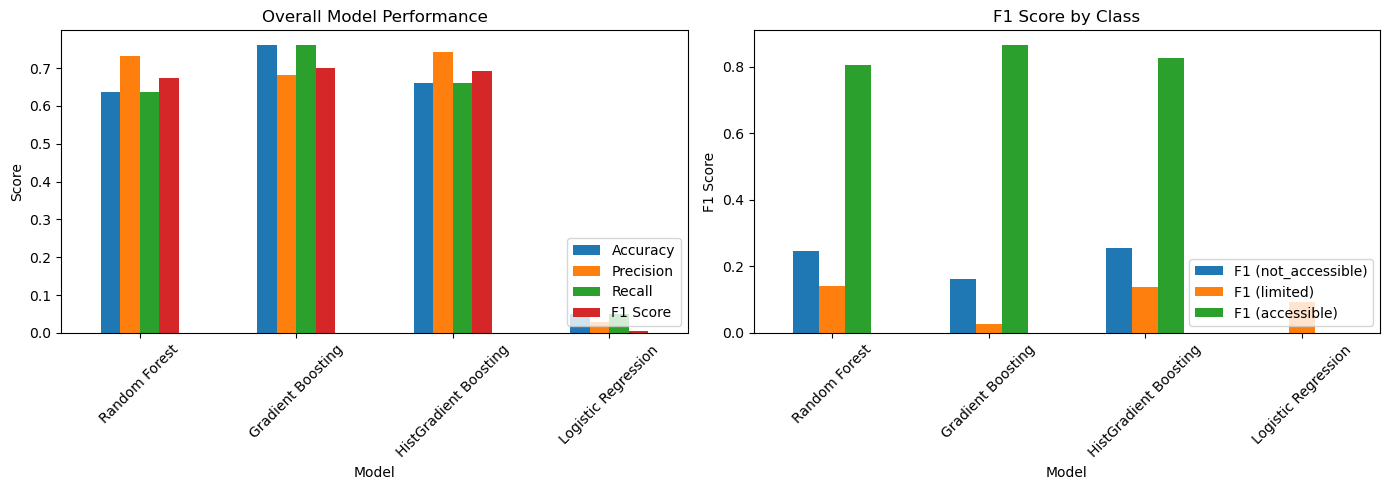

In [ ]:
# Compare models
print("=" * 80)
print("MODEL COMPARISON")
print("=" * 80)

metrics_df = pd.DataFrame({
    name: {
        'Accuracy': res['accuracy'],
        'Precision': res['precision'],
        'Recall': res['recall'],
        'F1 Score': res['f1'],
        'F1 (not_accessible)': res['f1_per_class'][0],
        'F1 (limited)': res['f1_per_class'][1],
        'F1 (accessible)': res['f1_per_class'][2]
    }
    for name, res in results.items()
}).T

print(metrics_df.round(4))

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall metrics
metrics_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].plot(kind='bar', ax=axes[0])
axes[0].set_title('Overall Model Performance')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Score')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(loc='lower right')

# Per-class F1
metrics_df[['F1 (not_accessible)', 'F1 (limited)', 'F1 (accessible)']].plot(kind='bar', ax=axes[1])
axes[1].set_title('F1 Score by Class')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('F1 Score')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()


BEST MODEL: Gradient Boosting

CLASSIFICATION REPORT:
                precision    recall  f1-score   support

not_accessible       0.38      0.10      0.16     29717
       limited       0.06      0.02      0.03      8309
    accessible       0.79      0.96      0.87    130453

      accuracy                           0.76    168479
     macro avg       0.41      0.36      0.35    168479
  weighted avg       0.68      0.76      0.70    168479



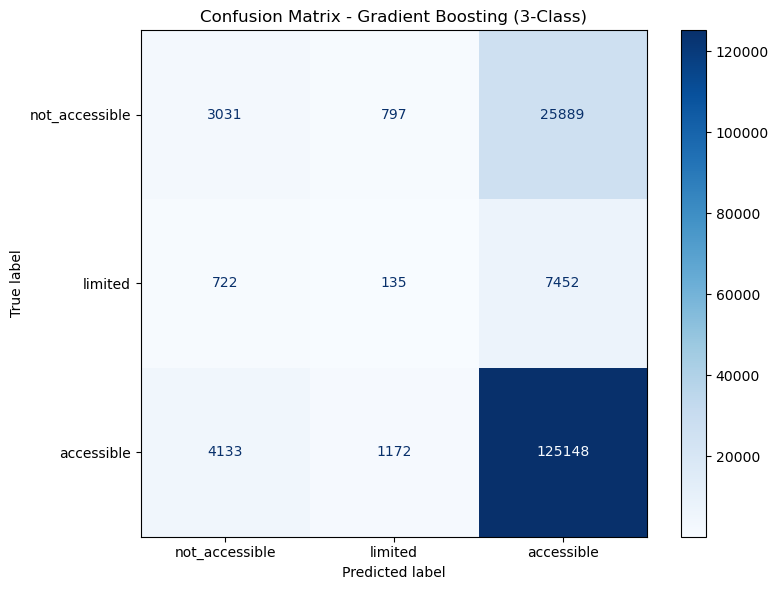

In [ ]:
# Select best model and show detailed report
best_model_name = max(results, key=lambda x: results[x]['f1'])
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']

print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model_name}")
print(f"{'='*80}")

print("\nCLASSIFICATION REPORT:")
print(classification_report(
    y_test, best_predictions,
    target_names=['not_accessible', 'limited', 'accessible']
))

# Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, best_predictions)
ConfusionMatrixDisplay(
    cm,
    display_labels=['not_accessible', 'limited', 'accessible']
).plot(ax=ax, cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name} (3-Class)')
plt.tight_layout()
plt.show()

FEATURE IMPORTANCE ANALYSIS

Top 30 Most Important Features:
                       feature  importance
                 historic_kerb    0.156536
              has_denomination    0.135606
                 amenity_15121    0.047932
           fee_Metro_de_Madrid    0.038352
                  has_operator    0.023775
                       has_fee    0.022192
                      has_shop    0.021056
                     has_bench    0.019511
                  has_delivery    0.018830
                   has_amenity    0.018574
door_https:__movilidad.malaga.    0.018217
                 rooms_numeric    0.016141
             has_opening_hours    0.016066
                       bench_0    0.015776
                  has_historic    0.015328
               has_reservation    0.012929
                     has_level    0.012099
            has_automatic_door    0.011608
                 amenity_48920    0.011400
               has_information    0.009967
                fee_restaurant    0.

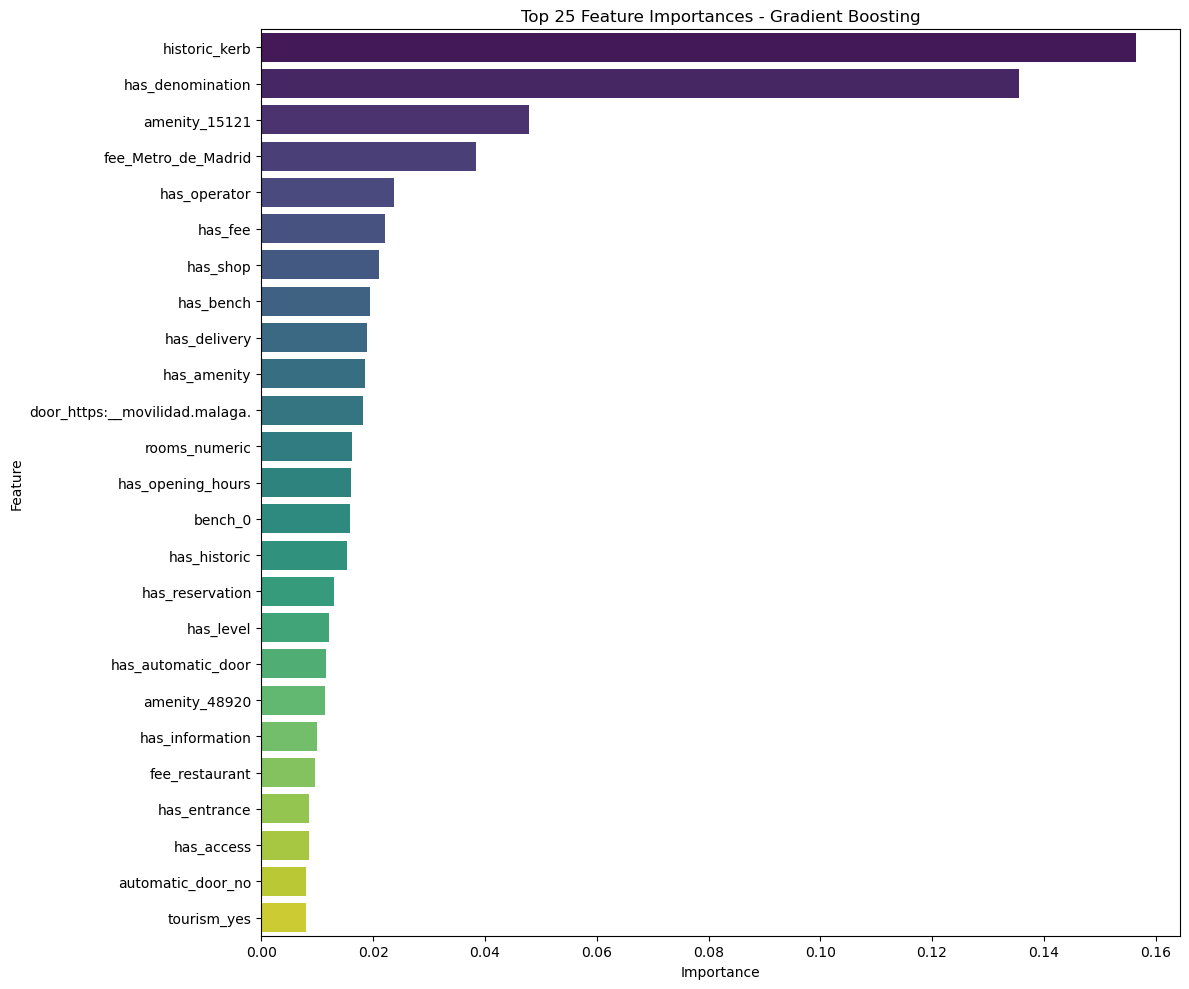

In [ ]:
# Feature Importance Analysis
print("=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 30 Most Important Features:")
    print(importance_df.head(30).to_string(index=False))
    
    # Plot top 25 features
    fig, ax = plt.subplots(figsize=(12, 10))
    top_features = importance_df.head(25)
    sns.barplot(data=top_features, x='importance', y='feature', ax=ax, palette='viridis')
    plt.title(f'Top 25 Feature Importances - {best_model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

## 9. Cross-Validation

In [ ]:
# Perform cross-validation on best model
print("=" * 80)
print("CROSS-VALIDATION (5-FOLD)")
print("=" * 80)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring='f1_weighted', n_jobs=-1)

print(f"\nModel: {best_model_name}")
print(f"CV F1 Scores: {cv_scores}")
print(f"Mean F1: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

CROSS-VALIDATION (5-FOLD)

Model: Gradient Boosting
CV F1 Scores: [0.77715592 0.77529873 0.77461481 0.77423276 0.77611641]
Mean F1: 0.7755 (+/- 0.0021)


## 10. Save the Improved 3-Class Model

In [ ]:
import joblib

# Save the improved model
model_filename = 'accessibility_model_3class_improved.joblib'

model_data = {
    'model': best_model,
    'model_name': best_model_name,
    'feature_columns': X.columns.tolist(),
    'useful_features': useful_features,
    'n_classes': 3,
    'class_mapping': {0: 'not_accessible', 1: 'limited', 2: 'accessible'},
    'training_samples': len(X_train),
    'n_features': len(X.columns),
    'metrics': {
        'accuracy': results[best_model_name]['accuracy'],
        'precision': results[best_model_name]['precision'],
        'recall': results[best_model_name]['recall'],
        'f1': results[best_model_name]['f1'],
        'f1_per_class': {
            'not_accessible': float(results[best_model_name]['f1_per_class'][0]),
            'limited': float(results[best_model_name]['f1_per_class'][1]),
            'accessible': float(results[best_model_name]['f1_per_class'][2])
        }
    }
}

joblib.dump(model_data, model_filename)

print(f"✅ 3-Class Model saved to: {model_filename}")
print(f"\nModel: {best_model_name}")
print(f"Training samples: {len(X_train):,}")
print(f"Number of features: {len(X.columns)}")
print(f"F1 Score (weighted): {results[best_model_name]['f1']:.4f}")
print(f"Accuracy: {results[best_model_name]['accuracy']:.4f}")

✅ 3-Class Model saved to: accessibility_model_3class_improved.joblib

Model: Gradient Boosting
Training samples: 27,463
Number of features: 798
F1 Score (weighted): 0.7004
Accuracy: 0.7616


## 11. Sample Predictions

In [ ]:
# Show sample predictions
sample_size = min(20, len(X_test))
sample_X = X_test.head(sample_size)
sample_y_true = y_test.head(sample_size)

sample_predictions = best_model.predict(sample_X)
sample_probabilities = best_model.predict_proba(sample_X)

# Create results DataFrame
prediction_results = pd.DataFrame({
    'True Class': sample_y_true.map(class_names).values,
    'Predicted Class': [class_names[p] for p in sample_predictions],
    'Prob(not_accessible)': sample_probabilities[:, 0].round(3),
    'Prob(limited)': sample_probabilities[:, 1].round(3),
    'Prob(accessible)': sample_probabilities[:, 2].round(3),
    'Correct': sample_y_true.values == sample_predictions
})

print("Sample Predictions:")
print(prediction_results.to_string())

Sample Predictions:
        True Class Predicted Class  Prob(not_accessible)  Prob(limited)  Prob(accessible)  Correct
0   not_accessible      accessible                 0.357          0.125             0.518    False
1   not_accessible      accessible                 0.330          0.148             0.522    False
2   not_accessible      accessible                 0.357          0.125             0.518    False
3   not_accessible      accessible                 0.358          0.187             0.455    False
4   not_accessible      accessible                 0.358          0.187             0.455    False
5   not_accessible  not_accessible                 0.530          0.150             0.320     True
6   not_accessible  not_accessible                 0.633          0.075             0.292     True
7   not_accessible  not_accessible                 0.666          0.072             0.262     True
8   not_accessible  not_accessible                 0.429          0.199             0.372

## 12. Address Class Imbalance - Train with SMOTE

The "limited" class has poor performance due to class imbalance. Let's try SMOTE (Synthetic Minority Over-sampling Technique) to improve the model.

In [ ]:
# Install imblearn if not present
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    print("imblearn already installed!")
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'imbalanced-learn'])
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    print("imblearn installed successfully!")

imblearn already installed!


In [ ]:
# Apply SMOTE to balance classes
print("=" * 80)
print("APPLYING SMOTE TO BALANCE CLASSES")
print("=" * 80)

print(f"\nOriginal class distribution in training set:")
print(y_train.value_counts())

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"\nResampled class distribution:")
from collections import Counter
print(Counter(y_train_resampled))
print(f"\nOriginal training size: {len(X_train):,}")
print(f"Resampled training size: {len(X_train_resampled):,}")

APPLYING SMOTE TO BALANCE CLASSES

Original class distribution in training set:
target_3class
2    17200
0     7118
1     3145
Name: count, dtype: int64

Resampled class distribution:
Counter({2: 17200, 1: 17200, 0: 17200})

Original training size: 27,463
Resampled training size: 51,600


In [ ]:
# Train models on balanced data
print("=" * 80)
print("TRAINING ON BALANCED DATA")
print("=" * 80)

# Use HistGradientBoosting for faster training on resampled data
from sklearn.ensemble import HistGradientBoostingClassifier

models_balanced = {
    'HistGradient Boosting (Balanced)': HistGradientBoostingClassifier(
        max_iter=300,
        max_depth=12,
        learning_rate=0.1,
        random_state=42,
        class_weight='balanced'
    ),
    'Random Forest (Balanced)': RandomForestClassifier(
        n_estimators=200,
        max_depth=18,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    )
}

results_balanced = {}

for name, model in models_balanced.items():
    print(f"\n{'='*60}")
    print(f"Training {name} on SMOTE-balanced data...")
    print(f"{'='*60}")
    
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # Per-class metrics
    f1_per_class = f1_score(y_test, y_pred, average=None, zero_division=0)
    
    results_balanced[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'f1_per_class': f1_per_class,
        'predictions': y_pred
    }
    
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision (weighted): {precision:.4f}")
    print(f"  Recall (weighted): {recall:.4f}")
    print(f"  F1 Score (weighted): {f1:.4f}")
    print(f"  F1 per class: not_accessible={f1_per_class[0]:.4f}, limited={f1_per_class[1]:.4f}, accessible={f1_per_class[2]:.4f}")

TRAINING ON BALANCED DATA

Training HistGradient Boosting (Balanced) on SMOTE-balanced data...
  Accuracy: 0.6848
  Precision (weighted): 0.7192
  Recall (weighted): 0.6848
  F1 Score (weighted): 0.6972
  F1 per class: not_accessible=0.2513, limited=0.1271, accessible=0.8351

Training Random Forest (Balanced) on SMOTE-balanced data...
  Accuracy: 0.6501
  Precision (weighted): 0.7239
  Recall (weighted): 0.6501
  F1 Score (weighted): 0.6780
  F1 per class: not_accessible=0.2235, limited=0.1417, accessible=0.8157


COMPARISON: BALANCED VS IMBALANCED TRAINING
                                  Accuracy  F1 (weighted)  \
Random Forest                       0.6368         0.6745   
Gradient Boosting                   0.7616         0.7004   
HistGradient Boosting               0.6606         0.6928   
Logistic Regression                 0.0493         0.0047   
HistGradient Boosting (Balanced)    0.6848         0.6972   
Random Forest (Balanced)            0.6501         0.6780   

                                  F1 (not_accessible)  F1 (limited)  \
Random Forest                                  0.2468        0.1416   
Gradient Boosting                              0.1612        0.0259   
HistGradient Boosting                          0.2561        0.1378   
Logistic Regression                            0.0001        0.0940   
HistGradient Boosting (Balanced)               0.2513        0.1271   
Random Forest (Balanced)                       0.2235        0.1417   

                              

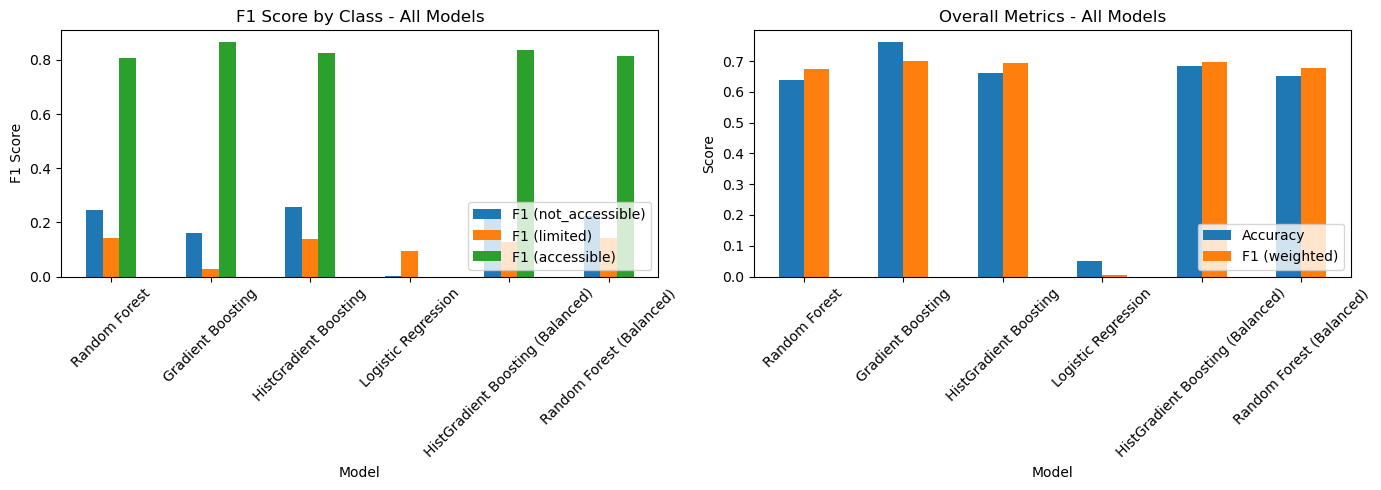

In [ ]:
# Compare balanced vs imbalanced model performance
print("=" * 80)
print("COMPARISON: BALANCED VS IMBALANCED TRAINING")
print("=" * 80)

# Combine results
all_results = {**results, **results_balanced}

comparison_df = pd.DataFrame({
    name: {
        'Accuracy': res['accuracy'],
        'F1 (weighted)': res['f1'],
        'F1 (not_accessible)': res['f1_per_class'][0],
        'F1 (limited)': res['f1_per_class'][1],
        'F1 (accessible)': res['f1_per_class'][2]
    }
    for name, res in all_results.items()
}).T

print(comparison_df.round(4))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Per-class F1 comparison
comparison_df[['F1 (not_accessible)', 'F1 (limited)', 'F1 (accessible)']].plot(kind='bar', ax=axes[0])
axes[0].set_title('F1 Score by Class - All Models')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('F1 Score')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(loc='lower right')

# Overall metrics
comparison_df[['Accuracy', 'F1 (weighted)']].plot(kind='bar', ax=axes[1])
axes[1].set_title('Overall Metrics - All Models')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Score')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

\n================================================================================
BEST BALANCED MODEL: HistGradient Boosting (Balanced)
\nCLASSIFICATION REPORT:
                precision    recall  f1-score   support

not_accessible       0.33      0.20      0.25     29717
       limited       0.09      0.25      0.13      8309
    accessible       0.85      0.82      0.84    130453

      accuracy                           0.68    168479
     macro avg       0.42      0.42      0.40    168479
  weighted avg       0.72      0.68      0.70    168479



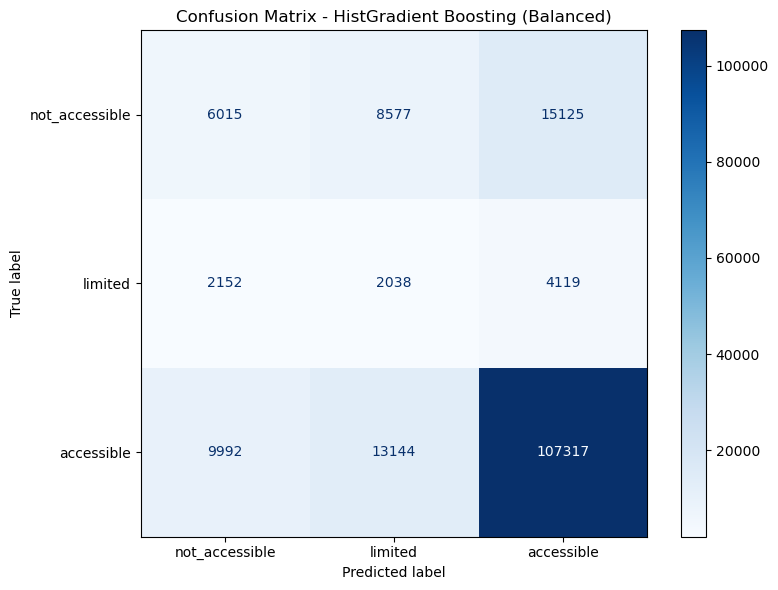

In [ ]:
# Best balanced model classification report
best_balanced_name = max(results_balanced, key=lambda x: results_balanced[x]['f1'])
best_balanced_model = results_balanced[best_balanced_name]['model']
best_balanced_pred = results_balanced[best_balanced_name]['predictions']

print(f"\\n{'='*80}")
print(f"BEST BALANCED MODEL: {best_balanced_name}")
print(f"{'='*80}")

print("\\nCLASSIFICATION REPORT:")
print(classification_report(
    y_test, best_balanced_pred,
    target_names=['not_accessible', 'limited', 'accessible']
))

# Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, best_balanced_pred)
ConfusionMatrixDisplay(
    cm,
    display_labels=['not_accessible', 'limited', 'accessible']
).plot(ax=ax, cmap='Blues')
plt.title(f'Confusion Matrix - {best_balanced_name}')
plt.tight_layout()
plt.show()

In [ ]:
# Save BOTH models - one optimized for overall F1, one for balanced class performance
all_results = {**results, **results_balanced}

# Best overall F1
best_overall_name = max(all_results, key=lambda x: all_results[x]['f1'])
best_overall = all_results[best_overall_name]

# Best for minority classes (limited + not_accessible)
def minority_score(name):
    res = all_results[name]
    return (res['f1_per_class'][0] + res['f1_per_class'][1]) / 2

best_balanced_name = max(all_results, key=minority_score)
best_balanced = all_results[best_balanced_name]

# Save both models
for model_type, name, res, filename in [
    ('overall', best_overall_name, best_overall, 'accessibility_model_3class_best_overall.joblib'),
    ('balanced', best_balanced_name, best_balanced, 'accessibility_model_3class_best_balanced.joblib')
]:
    model_data = {
        'model': res['model'],
        'model_name': name,
        'feature_columns': X.columns.tolist(),
        'useful_features': useful_features,
        'n_classes': 3,
        'class_mapping': {0: 'not_accessible', 1: 'limited', 2: 'accessible'},
        'n_features': len(X.columns),
        'optimization_target': model_type,
        'metrics': {
            'accuracy': res['accuracy'],
            'precision': res['precision'],
            'recall': res['recall'],
            'f1': res['f1'],
            'f1_per_class': {
                'not_accessible': float(res['f1_per_class'][0]),
                'limited': float(res['f1_per_class'][1]),
                'accessible': float(res['f1_per_class'][2])
            }
        }
    }
    joblib.dump(model_data, filename)
    print(f"\\n✅ Saved: {filename}")
    print(f"   Model: {name}")
    print(f"   Optimization: {model_type}")
    print(f"   F1 (weighted): {res['f1']:.4f}")
    print(f"   F1 (not_accessible): {res['f1_per_class'][0]:.4f}")
    print(f"   F1 (limited): {res['f1_per_class'][1]:.4f}")
    print(f"   F1 (accessible): {res['f1_per_class'][2]:.4f}")

\n✅ Saved: accessibility_model_3class_best_overall.joblib
   Model: Gradient Boosting
   Optimization: overall
   F1 (weighted): 0.7004
   F1 (not_accessible): 0.1612
   F1 (limited): 0.0259
   F1 (accessible): 0.8662
\n✅ Saved: accessibility_model_3class_best_balanced.joblib
   Model: HistGradient Boosting
   Optimization: balanced
   F1 (weighted): 0.6928
   F1 (not_accessible): 0.2561
   F1 (limited): 0.1378
   F1 (accessible): 0.8276


## 10. Train Final Model with Geographic Split (Production)

In [ ]:
# Train final production model using GEOGRAPHIC SPLIT to ensure realistic generalization
# This avoids spatial leakage that inflates metrics with random splits

print("=" * 80)
print("TRAINING FINAL MODEL WITH GEOGRAPHIC SPLIT")
print("=" * 80)

# Use the geographic train/test split already created
print(f"\nTraining on: {X_train_geo.shape[0]:,} samples (Europe)")
print(f"Testing on: {X_test_geo.shape[0]:,} samples (Other continents)")

# Train HistGradientBoosting with class balancing - best performer in our tests
from sklearn.ensemble import HistGradientBoostingClassifier

final_model = HistGradientBoostingClassifier(
    max_iter=200,
    max_depth=12,
    learning_rate=0.1,
    min_samples_leaf=20,
    max_leaf_nodes=50,
    random_state=42,
    class_weight='balanced',
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.1
)

print("\nTraining final model...")
final_model.fit(X_train_geo, y_train_geo)
print("✅ Training complete!")

# Evaluate on geographic test set (realistic performance)
y_pred_final = final_model.predict(X_test_geo)
final_acc = accuracy_score(y_test_geo, y_pred_final)
final_f1_macro = f1_score(y_test_geo, y_pred_final, average='macro')
final_f1_weighted = f1_score(y_test_geo, y_pred_final, average='weighted')
final_f1_per_class = f1_score(y_test_geo, y_pred_final, average=None)

print("\n" + "-" * 60)
print("FINAL MODEL PERFORMANCE (Geographic Test Set)")
print("-" * 60)
print(f"Accuracy:      {final_acc:.4f}")
print(f"F1-Macro:      {final_f1_macro:.4f}")
print(f"F1-Weighted:   {final_f1_weighted:.4f}")
print(f"\nPer-class F1 scores:")
print(f"  not_accessible: {final_f1_per_class[0]:.4f}")
print(f"  limited:        {final_f1_per_class[1]:.4f}")
print(f"  accessible:     {final_f1_per_class[2]:.4f}")

print("\n" + "-" * 60)
print("Classification Report:")
print("-" * 60)
print(classification_report(y_test_geo, y_pred_final, 
                            target_names=['not_accessible', 'limited', 'accessible']))

TRAINING FINAL MODEL WITH GEOGRAPHIC SPLIT

Training on: 27,463 samples (Europe)
Testing on: 168,479 samples (Other continents)

Training final model...
✅ Training complete!

------------------------------------------------------------
FINAL MODEL PERFORMANCE (Geographic Test Set)
------------------------------------------------------------
Accuracy:      0.6694
F1-Macro:      0.4066
F1-Weighted:   0.6939

Per-class F1 scores:
  not_accessible: 0.2426
  limited:        0.1456
  accessible:     0.8317

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
                precision    recall  f1-score   support

not_accessible       0.36      0.18      0.24     29717
       limited       0.09      0.36      0.15      8309
    accessible       0.87      0.80      0.83    130453

      accuracy                           0.67    168479
     macro avg       0.44      0.45      0.41    168479
  weighted

In [ ]:
# Save the geographically-trained model for production
import joblib

geo_model_filename = 'accessibility_model_geographic.joblib'

geo_model_data = {
    'model': final_model,
    'model_name': 'HistGradientBoostingClassifier (Geographic Split)',
    'feature_columns': X.columns.tolist(),
    'useful_features': useful_features,
    'n_classes': 3,
    'class_mapping': {0: 'not_accessible', 1: 'limited', 2: 'accessible'},
    'labels': ['not_accessible', 'limited', 'accessible'],
    'n_features': len(X.columns),
    'training_approach': 'geographic_split',
    'train_regions': train_regions,
    'test_regions': test_regions,
    'metrics': {
        'accuracy': float(final_acc),
        'f1_macro': float(final_f1_macro),
        'f1_weighted': float(final_f1_weighted),
        'f1_per_class': {
            'not_accessible': float(final_f1_per_class[0]),
            'limited': float(final_f1_per_class[1]),
            'accessible': float(final_f1_per_class[2])
        }
    },
    'geographic_cv_results': {
        'mean_f1_macro': float(results_df['f1_macro'].mean()),
        'std_f1_macro': float(results_df['f1_macro'].std()),
        'per_region': results_df.to_dict('records')
    }
}

joblib.dump(geo_model_data, geo_model_filename)
print(f"✅ Saved: {geo_model_filename}")

# Also save as the worldwide model (used by ONNX converter)
worldwide_filename = 'accessibility_model_worldwide.joblib'
joblib.dump(geo_model_data, worldwide_filename)
print(f"✅ Saved: {worldwide_filename}")

print("\n📋 Model includes geographic generalization metrics:")
print(f"   Mean F1-macro across regions: {results_df['f1_macro'].mean():.3f} (±{results_df['f1_macro'].std():.3f})")

✅ Saved: accessibility_model_geographic.joblib
✅ Saved: accessibility_model_worldwide.joblib

📋 Model includes geographic generalization metrics:
   Mean F1-macro across regions: 0.253 (±0.113)


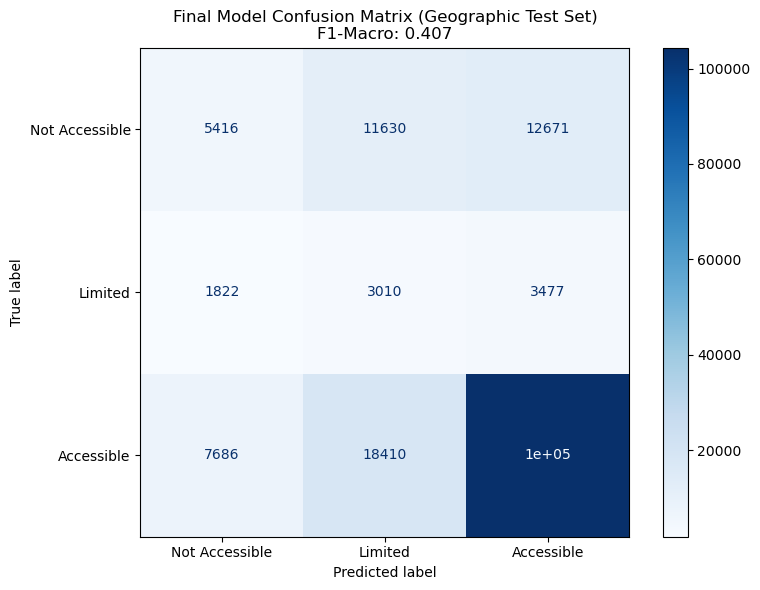


SAMPLE PREDICTIONS ON TEST SET
  ✓ Pred: not_accessible  | Actual: not_accessible  | Confidence: 0.43
  ✓ Pred: not_accessible  | Actual: not_accessible  | Confidence: 0.41
  ✓ Pred: not_accessible  | Actual: not_accessible  | Confidence: 0.43
  ✗ Pred: limited         | Actual: not_accessible  | Confidence: 0.44
  ✗ Pred: limited         | Actual: not_accessible  | Confidence: 0.44
  ✗ Pred: accessible      | Actual: not_accessible  | Confidence: 0.50
  ✓ Pred: not_accessible  | Actual: not_accessible  | Confidence: 0.51
  ✓ Pred: not_accessible  | Actual: not_accessible  | Confidence: 0.56
  ✓ Pred: not_accessible  | Actual: not_accessible  | Confidence: 0.53
  ✓ Pred: not_accessible  | Actual: not_accessible  | Confidence: 0.49


In [ ]:
# Visualize final model confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm_final = confusion_matrix(y_test_geo, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_final, 
                               display_labels=['Not Accessible', 'Limited', 'Accessible'])
disp.plot(ax=ax, cmap='Blues', colorbar=True)
ax.set_title(f'Final Model Confusion Matrix (Geographic Test Set)\nF1-Macro: {final_f1_macro:.3f}')
plt.tight_layout()
plt.show()

# Show sample predictions with confidence
print("\n" + "=" * 80)
print("SAMPLE PREDICTIONS ON TEST SET")
print("=" * 80)

# Get probability predictions
y_proba = final_model.predict_proba(X_test_geo[:10])
sample_preds = final_model.predict(X_test_geo[:10])
sample_actual = y_test_geo.iloc[:10].values

for i in range(10):
    pred_label = class_names[sample_preds[i]]
    actual_label = class_names[sample_actual[i]]
    confidence = max(y_proba[i])
    correct = "✓" if sample_preds[i] == sample_actual[i] else "✗"
    print(f"  {correct} Pred: {pred_label:15s} | Actual: {actual_label:15s} | Confidence: {confidence:.2f}")

## Summary

This improved notebook trained a **3-class wheelchair accessibility classifier** with the following enhancements:

**Improvements Made:**
1. **More Features**: Analyzed and used ~70+ OSM features vs ~18 in original
2. **Better Feature Engineering**: 
   - Boolean features (yes/no conversion)
   - Numeric features (level, floors, stars)
   - Interaction features (auto_door + entrance)
   - Ground level indicator
3. **3-Class Classification**: 
   - `accessible` (yes + designated combined)
   - `limited`
   - `not_accessible`
4. **Additional Models**: HistGradientBoosting for better performance
5. **Better Evaluation**: Per-class F1 scores, cross-validation

**Key Features for Accessibility Prediction:**
- Place type (amenity, shop, tourism, healthcare)
- Physical access (entrance, door, automatic_door, barrier, kerb)
- Facilities (toilets:wheelchair, changing_table, bench)
- Building structure (level, floor, indoor)
- Services (drive_through, outdoor_seating)
- Brand/operator (chain stores often more accessible)